# 결론
---
아래 전략을 사용할때,  
주문량을 1~3주차 앞당기면 비용을 조금 더 줄일 수 있지만,  
전반적으로 한번 부족재고가 발생하면 전체적으로 부족재고가 연쇄적으로 발생하는 횟수가 많아 진다.

특히, 공장쪽에 가까울 수록 부족재고 발생시,  
부족재고에서 재고량으로 전환하는 시기가 길어지므로,  
해당 전략을 사용시, 공장쪽에 100개 이상의 재고를 쌓아두는 것이 비용을 조금 더 줄일 수 있다.


In [ ]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import compiled_utils as utils
from torch.optim import Adam
from delayed_queue import DelayedQueue
from ledger import Ledger
from tqdm import tqdm

In [2]:
class BeerLoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,pred,history_ledger):#,x2):
        history_score = ((torch.abs(history_ledger[...,-3])*1)+(torch.abs(history_ledger[...,-2])*2)).sum()
        backlog = torch.abs(pred[...,-3])*1
        stock = torch.abs(pred[...,-2])*2
        return ((backlog+stock)).sum()+ history_score#*0.75
        

In [3]:
episode = 130

In [4]:
env = utils.Environment()
factory_net = utils.Factory(2)
distributor_net = utils.Factory(2)
wholesale_net = utils.Factory(2)
retailer_net = utils.Factory(2)

In [5]:
criterion = BeerLoss()
factory_optimizer = Adam(factory_net.parameters(),lr=0.0001)
distributor_optimizer = Adam(distributor_net.parameters(),lr=0.0001)
wholesale_optimizer = Adam(wholesale_net.parameters(),lr=0.0001)

loss_calculator = utils.LossCalculator2(env,criterion)

In [6]:
for ep in tqdm(range(episode)):
    env.reset()
    losses = []
    for rnd in range(60):
        factory_loss = loss_calculator.calculateFactoryLoss(factory_net)
        distributor_loss = loss_calculator.calculateDistributorLoss(distributor_net)
        wholesale_loss = loss_calculator.calculateWholesaleLoss(wholesale_net)
        retailer_loss = loss_calculator.calculateRetailerLoss(retailer_net)
        loss = (factory_loss + distributor_loss+wholesale_loss+retailer_loss)
        loss.backward()
        factory_optimizer.step()
        distributor_optimizer.step()
        losses.append(loss.item())
        
    if(ep%10==0):
        print(f"[epoch={ep}] avgLoss: {np.mean(losses)}")
        print("[factory ledger]")
        display(env.getFactoryLedger().getLedger())
        print("[distributor ledger]")
        display(env.getDistributorLedger().getLedger())

        print("[wholesale ledger]")
        display(env.getWholesaleLedger().getLedger())

        print("[retailer ledger]")
        display(env.getRetailerLedger().getLedger())
        if(ep>50):
            env.getFactoryLedger().getLedger().to_csv(f"[ep{ep}]factory_ledger.csv")
            env.getDistributorLedger().getLedger().to_csv(f"[ep{ep}]distributor_ledger.csv")
            env.getWholesaleLedger().getLedger().to_csv(f"[ep{ep}]wholesale_ledger.csv")
            env.getRetailerLedger().getLedger().to_csv(f"[ep{ep}]retailer_ledger.csv")

  0%|                                                                                          | 0/130 [00:00<?, ?it/s]

[epoch=0] avgLoss: 6160.1
[factory ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,4,16,7,7,7,0,9,0
1,0,9,0,0,0,0,9,15
2,15,24,15,15,15,0,9,15
3,15,24,15,15,15,0,9,0
4,0,9,5,5,5,0,4,10
...,...,...,...,...,...,...,...,...
56,19,19,4,42,18,24,0,19
57,19,19,9,33,18,15,0,19
58,19,19,19,34,18,16,0,19
59,19,19,19,35,18,17,0,19


[distributor ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,3,15,7,7,7,0,8,0
1,0,8,0,0,0,0,8,15
2,15,23,5,5,5,0,18,15
3,15,33,4,4,4,0,29,5
4,5,34,19,19,19,0,15,0
...,...,...,...,...,...,...,...,...
56,18,18,19,71,17,54,0,9
57,18,18,19,73,17,56,0,19
58,18,18,4,60,17,43,0,19
59,18,18,19,62,17,45,0,9


[wholesale ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,2,14,6,6,6,0,8,0
1,0,8,0,0,0,0,8,5
2,5,13,15,15,12,3,0,4
3,4,4,15,18,3,15,0,19
4,19,19,0,15,15,0,4,0
...,...,...,...,...,...,...,...,...
56,17,17,20,121,16,105,0,19
57,17,17,0,105,16,89,0,4
58,17,17,15,104,16,88,0,19
59,17,17,0,88,16,72,0,19


[retailer ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,3,15,5,5,5,0,10,0
1,0,10,0,0,0,0,10,15
2,12,22,15,15,15,0,7,15
3,3,10,9,9,9,0,1,0
4,15,16,4,4,4,0,12,20
...,...,...,...,...,...,...,...,...
56,16,119,5,5,5,0,114,0
57,16,130,7,7,7,0,123,15
58,16,139,15,15,15,0,124,0
59,16,140,13,13,13,0,127,15


  8%|██████▏                                                                          | 10/130 [01:58<23:15, 11.63s/it]

[epoch=10] avgLoss: 6544.016666666666
[factory ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,2,14,9,9,9,0,5,0
1,0,5,0,0,0,0,5,5
2,5,10,5,5,5,0,5,5
3,5,10,5,5,5,0,5,5
4,5,10,5,5,5,0,5,5
...,...,...,...,...,...,...,...,...
56,20,21,0,0,0,0,21,5
57,5,26,0,0,0,0,26,5
58,5,31,0,0,0,0,31,5
59,5,36,0,0,0,0,36,5


[distributor ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,4,16,1,1,1,0,15,0
1,0,15,0,0,0,0,15,5
2,5,20,5,5,5,0,15,5
3,5,20,5,5,5,0,15,5
4,5,20,5,5,5,0,15,5
...,...,...,...,...,...,...,...,...
56,0,111,5,5,5,0,106,0
57,0,106,5,5,5,0,101,0
58,0,101,5,5,5,0,96,0
59,0,96,5,5,5,0,91,0


[wholesale ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,3,15,2,2,2,0,13,0
1,0,13,0,0,0,0,13,5
2,5,18,5,5,5,0,13,5
3,5,18,5,5,5,0,13,5
4,5,18,4,4,4,0,14,5
...,...,...,...,...,...,...,...,...
56,5,67,5,5,5,0,62,5
57,5,67,4,4,4,0,63,5
58,5,68,19,19,19,0,49,5
59,5,54,19,19,19,0,35,5


[retailer ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,2,14,2,2,2,0,12,0
1,0,12,0,0,0,0,12,5
2,5,17,13,13,13,0,4,5
3,5,9,14,14,8,6,0,4
4,4,4,20,26,3,23,0,19
...,...,...,...,...,...,...,...,...
56,5,7,17,17,6,11,0,4
57,4,4,19,30,3,27,0,19
58,19,19,6,33,18,15,0,19
59,19,19,4,19,19,0,0,20


 15%|████████████▍                                                                    | 20/130 [03:54<21:21, 11.65s/it]

[epoch=20] avgLoss: 6711.833333333333
[factory ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,4,16,4,4,4,0,12,0
1,0,12,0,0,0,0,12,5
2,5,17,5,5,5,0,12,0
3,0,12,5,5,5,0,7,5
4,5,12,5,5,5,0,7,5
...,...,...,...,...,...,...,...,...
56,5,24,5,5,5,0,19,5
57,5,24,5,5,5,0,19,5
58,5,24,5,5,5,0,19,5
59,5,24,5,5,5,0,19,5


[distributor ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,3,15,8,8,8,0,7,0
1,0,7,0,0,0,0,7,5
2,5,12,5,5,5,0,7,5
3,5,12,5,5,5,0,7,5
4,5,12,5,5,5,0,7,5
...,...,...,...,...,...,...,...,...
56,5,79,5,5,5,0,74,5
57,5,79,5,5,5,0,74,5
58,5,79,5,5,5,0,74,5
59,5,79,5,5,5,0,74,5


[wholesale ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,2,14,4,4,4,0,10,0
1,0,10,0,0,0,0,10,5
2,5,15,5,5,5,0,10,5
3,5,15,5,5,5,0,10,5
4,5,15,5,5,5,0,10,5
...,...,...,...,...,...,...,...,...
56,5,57,5,5,5,0,52,5
57,5,57,5,5,5,0,52,5
58,5,57,4,4,4,0,53,5
59,5,58,14,14,14,0,44,5


[retailer ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,1,13,4,4,4,0,9,0
1,0,9,0,0,0,0,9,5
2,5,14,4,4,4,0,10,5
3,5,15,12,12,12,0,3,5
4,5,8,14,14,7,7,0,4
...,...,...,...,...,...,...,...,...
56,5,19,13,13,13,0,6,5
57,5,11,12,12,10,2,0,4
58,4,4,18,20,3,17,0,14
59,14,14,4,21,13,8,0,19


 23%|██████████████████▋                                                              | 30/130 [05:52<19:22, 11.63s/it]

[epoch=30] avgLoss: 6214.066666666667
[factory ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,4,16,2,2,2,0,14,0
1,0,14,0,0,0,0,14,5
2,5,19,5,5,5,0,14,5
3,5,19,5,5,5,0,14,5
4,5,19,5,5,5,0,14,5
...,...,...,...,...,...,...,...,...
56,5,24,5,5,5,0,19,5
57,5,24,5,5,5,0,19,5
58,5,24,5,5,5,0,19,5
59,5,24,5,5,5,0,19,5


[distributor ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,3,15,9,9,9,0,6,0
1,0,6,0,0,0,0,6,5
2,5,11,5,5,5,0,6,5
3,5,11,5,5,5,0,6,5
4,5,11,5,5,5,0,6,5
...,...,...,...,...,...,...,...,...
56,5,85,19,19,19,0,66,5
57,5,71,20,20,20,0,51,5
58,5,56,5,5,5,0,51,5
59,5,56,5,5,5,0,51,5


[wholesale ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,3,15,6,6,6,0,9,0
1,0,9,0,0,0,0,9,5
2,5,14,5,5,5,0,9,5
3,5,14,5,5,5,0,9,5
4,5,14,5,5,5,0,9,5
...,...,...,...,...,...,...,...,...
56,19,19,5,16,16,0,3,20
57,20,23,5,5,5,0,18,5
58,5,23,5,5,5,0,18,5
59,5,23,5,5,5,0,18,5


[retailer ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,2,14,9,9,9,0,5,0
1,0,5,0,0,0,0,5,5
2,5,10,4,4,4,0,6,5
3,5,11,6,6,6,0,5,5
4,5,10,13,13,9,4,0,4
...,...,...,...,...,...,...,...,...
56,16,19,14,14,14,0,5,5
57,5,10,0,0,0,0,10,5
58,5,15,6,6,6,0,9,5
59,5,14,5,5,5,0,9,5


 31%|████████████████████████▉                                                        | 40/130 [07:49<17:24, 11.61s/it]

[epoch=40] avgLoss: 3854.633333333333
[factory ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,4,16,4,4,4,0,12,0
1,0,12,0,0,0,0,12,5
2,5,17,5,5,5,0,12,5
3,5,17,5,5,5,0,12,5
4,5,17,5,5,5,0,12,5
...,...,...,...,...,...,...,...,...
56,19,19,19,49,18,31,0,19
57,19,19,19,50,18,32,0,19
58,19,19,19,51,18,33,0,19
59,19,19,19,52,18,34,0,19


[distributor ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,3,15,5,5,5,0,10,0
1,0,10,0,0,0,0,10,5
2,5,15,5,5,5,0,10,5
3,5,15,5,5,5,0,10,5
4,5,15,5,5,5,0,10,5
...,...,...,...,...,...,...,...,...
56,18,18,4,55,17,38,0,19
57,18,18,15,53,17,36,0,19
58,18,18,5,41,17,24,0,19
59,18,18,5,29,17,12,0,19


[wholesale ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,1,13,3,3,3,0,10,0
1,0,10,0,0,0,0,10,5
2,5,15,5,5,5,0,10,5
3,5,15,5,5,5,0,10,5
4,5,15,4,4,4,0,11,5
...,...,...,...,...,...,...,...,...
56,17,17,5,7,7,0,10,15
57,17,27,5,5,5,0,22,5
58,17,39,4,4,4,0,35,5
59,17,52,19,19,19,0,33,5


[retailer ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,4,16,1,1,1,0,15,0
1,0,15,0,0,0,0,15,5
2,5,20,19,19,19,0,1,5
3,5,6,9,9,5,4,0,4
4,4,4,6,10,3,7,0,19
...,...,...,...,...,...,...,...,...
56,7,13,6,6,6,0,7,5
57,5,12,19,19,11,8,0,4
58,4,4,18,26,3,23,0,19
59,19,19,7,30,18,12,0,19


 38%|███████████████████████████████▏                                                 | 50/130 [09:44<15:25, 11.57s/it]

[epoch=50] avgLoss: 6922.333333333333
[factory ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,1,13,6,6,6,0,7,0
1,0,7,0,0,0,0,7,5
2,5,12,5,5,5,0,7,5
3,5,12,5,5,5,0,7,5
4,5,12,5,5,5,0,7,5
...,...,...,...,...,...,...,...,...
56,15,27,0,0,0,0,27,5
57,5,32,0,0,0,0,32,5
58,5,37,0,0,0,0,37,5
59,5,42,0,0,0,0,42,5


[distributor ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,1,13,1,1,1,0,12,0
1,0,12,0,0,0,0,12,5
2,5,17,5,5,5,0,12,5
3,5,17,5,5,5,0,12,5
4,5,17,5,5,5,0,12,5
...,...,...,...,...,...,...,...,...
56,0,115,0,0,0,0,115,0
57,0,115,0,0,0,0,115,0
58,0,115,0,0,0,0,115,0
59,0,115,0,0,0,0,115,0


[wholesale ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,3,15,1,1,1,0,14,0
1,0,14,0,0,0,0,14,5
2,5,19,5,5,5,0,14,5
3,5,19,5,5,5,0,14,5
4,5,19,4,4,4,0,15,5
...,...,...,...,...,...,...,...,...
56,0,106,5,5,5,0,101,0
57,0,101,5,5,5,0,96,0
58,0,96,5,5,5,0,91,0
59,0,91,5,5,5,0,86,5


[retailer ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,3,15,8,8,8,0,7,0
1,0,7,0,0,0,0,7,5
2,5,12,4,4,4,0,8,5
3,5,13,18,18,12,6,0,4
4,4,4,16,22,3,19,0,19
...,...,...,...,...,...,...,...,...
56,5,31,12,12,12,0,19,5
57,5,24,14,14,14,0,10,5
58,5,15,13,13,13,0,2,5
59,5,7,14,14,6,8,0,4


 46%|█████████████████████████████████████▍                                           | 60/130 [11:39<13:25, 11.50s/it]

[epoch=60] avgLoss: 5706.7
[factory ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,2,14,9,9,9,0,5,0
1,0,5,0,0,0,0,5,5
2,5,10,5,5,5,0,5,5
3,5,10,5,5,5,0,5,5
4,5,10,5,5,5,0,5,5
...,...,...,...,...,...,...,...,...
56,19,19,5,14,14,0,5,20
57,20,25,0,0,0,0,25,5
58,5,30,0,0,0,0,30,5
59,5,35,0,0,0,0,35,5


[distributor ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,2,14,3,3,3,0,11,0
1,0,11,0,0,0,0,11,5
2,5,16,5,5,5,0,11,5
3,5,16,5,5,5,0,11,5
4,5,16,5,5,5,0,11,5
...,...,...,...,...,...,...,...,...
56,14,111,5,5,5,0,106,0
57,0,106,5,5,5,0,101,0
58,0,101,5,5,5,0,96,0
59,0,96,5,5,5,0,91,0


[wholesale ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,2,14,1,1,1,0,13,0
1,0,13,0,0,0,0,13,5
2,5,18,5,5,5,0,13,5
3,5,18,5,5,5,0,13,5
4,5,18,5,5,5,0,13,5
...,...,...,...,...,...,...,...,...
56,5,95,5,5,5,0,90,5
57,5,95,10,10,10,0,85,5
58,5,90,5,5,5,0,85,5
59,5,90,5,5,5,0,85,5


[retailer ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,4,16,5,5,5,0,11,0
1,0,11,0,0,0,0,11,5
2,5,16,0,0,0,0,16,5
3,5,21,9,9,9,0,12,5
4,5,17,5,5,5,0,12,5
...,...,...,...,...,...,...,...,...
56,5,5,2,2,2,0,3,10
57,10,13,1,1,1,0,12,5
58,5,17,17,17,17,0,0,5
59,5,5,2,2,2,0,3,10


 54%|███████████████████████████████████████████▌                                     | 70/130 [13:35<11:34, 11.58s/it]

[epoch=70] avgLoss: 6701.416666666667
[factory ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,1,13,8,8,8,0,5,0
1,0,5,0,0,0,0,5,5
2,5,10,5,5,5,0,5,5
3,5,10,5,5,5,0,5,5
4,5,10,5,5,5,0,5,5
...,...,...,...,...,...,...,...,...
56,20,23,5,5,5,0,18,5
57,5,23,0,0,0,0,23,5
58,5,28,0,0,0,0,28,5
59,5,33,0,0,0,0,33,5


[distributor ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,3,15,1,1,1,0,14,0
1,0,14,0,0,0,0,14,5
2,5,19,5,5,5,0,14,5
3,5,19,5,5,5,0,14,5
4,5,19,5,5,5,0,14,5
...,...,...,...,...,...,...,...,...
56,5,113,5,5,5,0,108,0
57,0,108,5,5,5,0,103,0
58,0,103,5,5,5,0,98,0
59,0,98,5,5,5,0,93,0


[wholesale ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,3,15,7,7,7,0,8,0
1,0,8,0,0,0,0,8,5
2,5,13,5,5,5,0,8,5
3,5,13,5,5,5,0,8,5
4,5,13,5,5,5,0,8,5
...,...,...,...,...,...,...,...,...
56,5,95,5,5,5,0,90,5
57,5,95,5,5,5,0,90,5
58,5,95,5,5,5,0,90,5
59,5,95,5,5,5,0,90,5


[retailer ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,4,16,9,9,9,0,7,0
1,0,7,0,0,0,0,7,5
2,5,12,4,4,4,0,8,5
3,5,13,7,7,7,0,6,5
4,5,11,11,11,11,0,0,5
...,...,...,...,...,...,...,...,...
56,5,37,16,16,16,0,21,5
57,5,26,19,19,19,0,7,5
58,5,12,9,9,9,0,3,5
59,5,8,7,7,7,0,1,5


 61%|█████████████████████████████████████████████████▏                               | 79/130 [15:19<09:50, 11.57s/it]

[epoch=80] avgLoss: 6590.583333333333
[factory ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,4,16,2,2,2,0,14,0
1,0,14,0,0,0,0,14,5
2,5,19,5,5,5,0,14,5
3,5,19,5,5,5,0,14,5
4,5,19,5,5,5,0,14,5
...,...,...,...,...,...,...,...,...
56,5,37,5,5,5,0,32,5
57,5,37,5,5,5,0,32,5
58,5,37,5,5,5,0,32,5
59,5,37,5,5,5,0,32,5


[distributor ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,2,14,6,6,6,0,8,0
1,0,8,0,0,0,0,8,5
2,5,13,5,5,5,0,8,5
3,5,13,5,5,5,0,8,5
4,5,13,5,5,5,0,8,5
...,...,...,...,...,...,...,...,...
56,5,95,5,5,5,0,90,5
57,5,95,5,5,5,0,90,5
58,5,95,5,5,5,0,90,5
59,5,95,4,4,4,0,91,5


[wholesale ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,2,14,4,4,4,0,10,0
1,0,10,0,0,0,0,10,5
2,5,15,5,5,5,0,10,5
3,5,15,5,5,5,0,10,5
4,5,15,4,4,4,0,11,5
...,...,...,...,...,...,...,...,...
56,5,37,19,19,19,0,18,5
57,5,23,19,19,19,0,4,5
58,5,9,19,19,8,11,0,4
59,4,4,19,30,3,27,0,19


[retailer ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,1,13,4,4,4,0,9,0
1,0,9,0,0,0,0,9,5
2,5,14,12,12,12,0,2,5
3,5,7,13,13,6,7,0,4
4,4,4,12,19,3,16,0,19
...,...,...,...,...,...,...,...,...
56,19,19,16,30,18,12,0,19
57,19,19,16,28,18,10,0,19
58,8,8,17,27,7,20,0,19
59,3,3,1,21,2,19,0,19


 69%|██████████████████████████████████████████████████████▋                        | 90/130 [1:30:05<41:29, 62.24s/it]

[epoch=90] avgLoss: 6417.05
[factory ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,1,13,8,8,8,0,5,0
1,0,5,0,0,0,0,5,5
2,5,10,5,5,5,0,5,5
3,5,10,5,5,5,0,5,5
4,5,10,5,5,5,0,5,5
...,...,...,...,...,...,...,...,...
56,5,42,5,5,5,0,37,5
57,5,42,5,5,5,0,37,5
58,5,42,5,5,5,0,37,5
59,5,42,5,5,5,0,37,5


[distributor ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,1,13,7,7,7,0,6,0
1,0,6,0,0,0,0,6,5
2,5,11,5,5,5,0,6,5
3,5,11,5,5,5,0,6,5
4,5,11,5,5,5,0,6,5
...,...,...,...,...,...,...,...,...
56,5,94,5,5,5,0,89,5
57,5,94,5,5,5,0,89,5
58,5,94,5,5,5,0,89,5
59,5,94,4,4,4,0,90,5


[wholesale ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,4,16,1,1,1,0,15,0
1,0,15,0,0,0,0,15,5
2,5,20,5,5,5,0,15,5
3,5,20,5,5,5,0,15,5
4,5,20,5,5,5,0,15,5
...,...,...,...,...,...,...,...,...
56,5,44,19,19,19,0,25,5
57,5,30,19,19,19,0,11,5
58,5,16,19,19,15,4,0,4
59,4,4,19,23,3,20,0,19


[retailer ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,3,15,9,9,9,0,6,0
1,0,6,0,0,0,0,6,5
2,5,11,3,3,3,0,8,5
3,5,13,1,1,1,0,12,5
4,5,17,15,15,15,0,2,5
...,...,...,...,...,...,...,...,...
56,19,19,13,33,18,15,0,19
57,19,19,17,32,18,14,0,19
58,15,15,18,32,14,18,0,19
59,3,3,18,36,2,34,0,19


 77%|████████████████████████████████████████████████████████████                  | 100/130 [1:31:20<04:30,  9.03s/it]

[epoch=100] avgLoss: 4442.833333333333
[factory ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,4,16,8,8,8,0,8,0
1,0,8,0,0,0,0,8,5
2,5,13,5,5,5,0,8,5
3,5,13,5,5,5,0,8,5
4,5,13,5,5,5,0,8,5
...,...,...,...,...,...,...,...,...
56,5,24,5,5,5,0,19,5
57,5,24,5,5,5,0,19,5
58,5,24,5,5,5,0,19,5
59,5,24,5,5,5,0,19,5


[distributor ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,4,16,7,7,7,0,9,0
1,0,9,0,0,0,0,9,5
2,5,14,5,5,5,0,9,5
3,5,14,5,5,5,0,9,5
4,5,14,5,5,5,0,9,5
...,...,...,...,...,...,...,...,...
56,5,23,5,5,5,0,18,5
57,5,23,5,5,5,0,18,5
58,5,23,5,5,5,0,18,5
59,5,23,4,4,4,0,19,5


[wholesale ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,1,13,6,6,6,0,7,0
1,0,7,0,0,0,0,7,5
2,5,12,5,5,5,0,7,5
3,5,12,4,4,4,0,8,5
4,5,13,19,19,12,7,0,4
...,...,...,...,...,...,...,...,...
56,5,25,4,4,4,0,21,5
57,5,26,19,19,19,0,7,5
58,5,12,20,20,11,9,0,4
59,4,4,5,14,3,11,0,19


[retailer ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,1,13,2,2,2,0,11,0
1,0,11,0,0,0,0,11,5
2,5,16,19,19,15,4,0,4
3,4,4,4,8,3,5,0,19
4,12,12,0,5,5,0,7,20
...,...,...,...,...,...,...,...,...
56,4,4,4,7,3,4,0,19
57,19,19,0,4,4,0,15,20
58,11,26,15,15,15,0,11,5
59,3,14,10,10,10,0,4,5


 85%|██████████████████████████████████████████████████████████████████            | 110/130 [1:32:32<02:23,  7.17s/it]

[epoch=110] avgLoss: 6853.133333333333
[factory ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,2,14,3,3,3,0,11,0
1,0,11,0,0,0,0,11,5
2,5,16,5,5,5,0,11,5
3,5,16,5,5,5,0,11,5
4,5,16,5,5,5,0,11,5
...,...,...,...,...,...,...,...,...
56,5,26,5,5,5,0,21,5
57,5,26,5,5,5,0,21,5
58,5,26,5,5,5,0,21,5
59,5,26,5,5,5,0,21,5


[distributor ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,4,16,8,8,8,0,8,0
1,0,8,0,0,0,0,8,5
2,5,13,5,5,5,0,8,5
3,5,13,5,5,5,0,8,5
4,5,13,5,5,5,0,8,5
...,...,...,...,...,...,...,...,...
56,5,88,5,5,5,0,83,5
57,5,88,5,5,5,0,83,5
58,5,88,5,5,5,0,83,5
59,5,88,5,5,5,0,83,5


[wholesale ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,4,16,8,8,8,0,8,0
1,0,8,0,0,0,0,8,5
2,5,13,5,5,5,0,8,5
3,5,13,4,4,4,0,9,5
4,5,14,19,19,13,6,0,4
...,...,...,...,...,...,...,...,...
56,5,36,5,5,5,0,31,5
57,5,36,5,5,5,0,31,5
58,5,36,5,5,5,0,31,5
59,5,36,9,9,9,0,27,5


[retailer ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,4,16,6,6,6,0,10,0
1,0,10,0,0,0,0,10,5
2,5,15,20,20,14,6,0,4
3,4,4,10,16,3,13,0,19
4,13,13,3,16,12,4,0,19
...,...,...,...,...,...,...,...,...
56,5,17,6,6,6,0,11,5
57,5,16,16,16,16,0,0,5
58,5,5,13,13,4,9,0,9
59,9,9,3,12,8,4,0,19


 92%|████████████████████████████████████████████████████████████████████████      | 120/130 [1:33:44<01:12,  7.28s/it]

[epoch=120] avgLoss: 4717.1
[factory ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,1,13,8,8,8,0,5,0
1,0,5,0,0,0,0,5,5
2,5,10,5,5,5,0,5,5
3,5,10,5,5,5,0,5,5
4,5,10,5,5,5,0,5,5
...,...,...,...,...,...,...,...,...
56,5,28,4,4,4,0,24,5
57,5,29,19,19,19,0,10,5
58,5,15,20,20,14,6,0,4
59,4,4,5,11,3,8,0,19


[distributor ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,1,13,9,9,9,0,4,0
1,0,4,0,0,0,0,4,5
2,5,9,5,5,5,0,4,5
3,5,9,5,5,5,0,4,5
4,5,9,5,5,5,0,4,5
...,...,...,...,...,...,...,...,...
56,4,4,5,9,3,6,0,19
57,19,19,5,11,11,0,8,20
58,14,22,5,5,5,0,17,5
59,3,20,5,5,5,0,15,5


[wholesale ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,3,15,4,4,4,0,11,0
1,0,11,0,0,0,0,11,5
2,5,16,5,5,5,0,11,5
3,5,16,5,5,5,0,11,5
4,5,16,5,5,5,0,11,5
...,...,...,...,...,...,...,...,...
56,3,18,5,5,5,0,13,5
57,11,24,4,4,4,0,20,5
58,5,25,19,19,19,0,6,5
59,5,11,20,20,10,10,0,4


[retailer ledger]


,입고,출고전_총재고,주문,총수요,출고량,부족재고,재고,총주문량
0,3,15,2,2,2,0,13,0
1,0,13,0,0,0,0,13,5
2,5,18,9,9,9,0,9,5
3,5,14,9,9,9,0,5,5
4,5,10,17,17,9,8,0,4
...,...,...,...,...,...,...,...,...
56,5,6,15,15,5,10,0,4
57,4,4,6,16,3,13,0,19
58,19,19,6,19,19,0,0,20
59,10,10,2,2,2,0,8,10


100%|██████████████████████████████████████████████████████████████████████████████| 130/130 [1:35:00<00:00, 43.85s/it]


In [7]:
factory_ledger = env.getFactoryLedger().getLedger()
distributor_ledger = env.getDistributorLedger().getLedger()
wholesale_ledger = env.getWholesaleLedger().getLedger()
retailer_ledger = env.getRetailerLedger().getLedger()


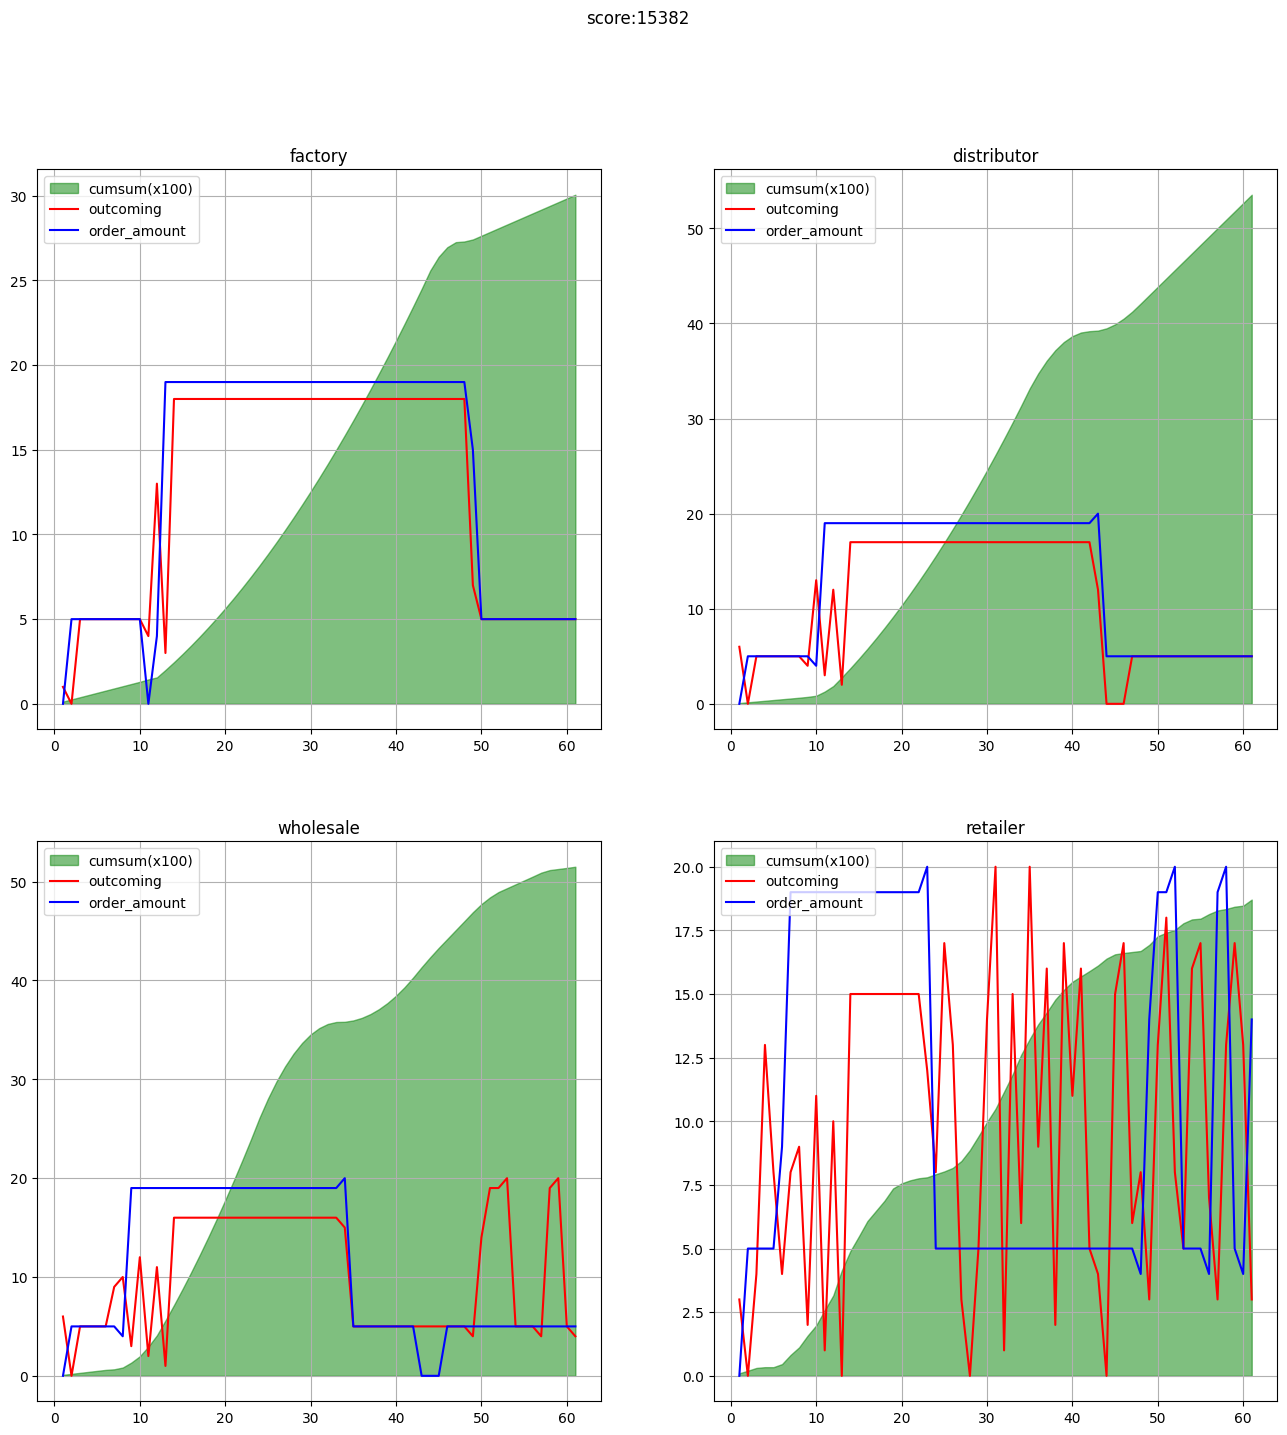

In [22]:
ledgers = {"factory":factory_ledger,"distributor":distributor_ledger,"wholesale":wholesale_ledger,"retailer":retailer_ledger}
fig,ax = plt.subplots(2,2,figsize=(16,16))
cum_sums = 0
for i,k in enumerate(ledgers.keys()):
    cum_sum = (ledgers[k]["부족재고"]*2 + ledgers[k]["재고"]).cumsum() 
    cum_sums += cum_sum.iloc[-1]
    outcoming = ledgers[k]["출고량"]
    order_amount = ledgers[k]["총주문량"]
    week = np.arange(1,ledgers[k].shape[0]+1)
    ax[i//2][i%2].grid()
    ax[i//2][i%2].set_title(k)
    ax[i//2][i%2].fill_between(week, cum_sum/100, color='g', alpha=0.5,label="cumsum(x100)")
    ax[i//2][i%2].plot(week,outcoming,color='r',label="outcoming")
    ax[i//2][i%2].plot(week,order_amount,color='b',label="order_amount")
    ax[i//2][i%2].legend(loc="upper left")
plt.suptitle("score:"+str(cum_sums))
plt.show()